In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
data = pd.read_csv("email_spam_indo.csv")
data.head()

,Kategori,Pesan
0,spam,Secara alami tak tertahankan identitas perusah...
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak..."


In [11]:
print("Jumlah baris:", len(data))

Jumlah baris: 2636


In [14]:
print(data.columns)

Index(['Kategori', 'Pesan'], dtype='object')


In [16]:
data['text_length'] = data['Pesan'].apply(len)
print("Panjang rata-rata:", data['text_length'].mean())

Panjang rata-rata: 1481.5201062215478


In [17]:
print("Jumlah duplikasi:", data.duplicated().sum())
data = data.drop_duplicates()

Jumlah duplikasi: 16


In [18]:
print("Jumlah data kosong:", data.isnull().sum())
data = data.dropna()

Jumlah data kosong: Kategori       0
Pesan          0
text_length    0
dtype: int64


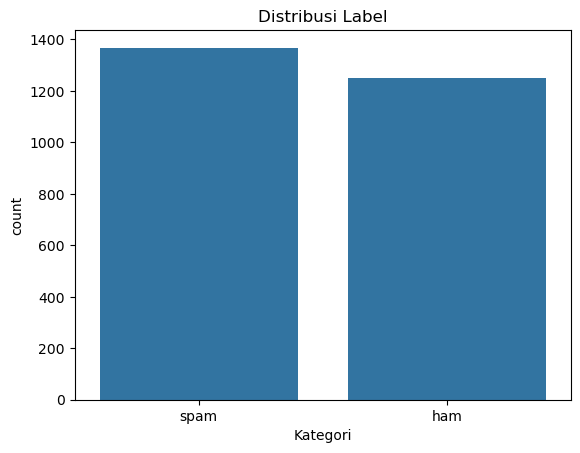

In [19]:
# Distribusi label
sns.countplot(x='Kategori', data=data)
plt.title("Distribusi Label")
plt.show()

In [34]:
data['tokens'] = data['Pesan'].apply(lambda x: re.findall(r'\b\w+\b', x.lower()))

In [39]:
stemmer = PorterStemmer()
data['stemmed'] = data['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

In [41]:
data['clean_text'] = data['stemmed'].apply(
    lambda x: ' '.join([word for word in x if word not in stop_words and word.isalpha()])
)

data[['Pesan','clean_text']].head()

,Pesan,clean_text
0,Secara alami tak tertahankan identitas perusah...,alami tertahankan identita perusahaan sulit pe...
1,Fanny Gunslinger Perdagangan Saham adalah Merr...,fanni gunsling perdagangan saham merril muzo c...
2,Rumah -rumah baru yang luar biasa menjadi muda...,rumah rumah mudah pemilik rumah disetujui pinj...
3,4 Permintaan Khusus Pencetakan Warna Informasi...,permintaan khusu pencetakan warna informasi ta...
4,"Jangan punya uang, dapatkan CD perangkat lunak...",uang dapatkan cd perangkat lunak kompatibilita...


In [43]:
# ============================
# 5. Text Vektorisasi
# ============================
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['clean_text'])
X = tokenizer.texts_to_sequences(data['clean_text'])
X = pad_sequences(X, maxlen=100)

In [44]:
y = pd.get_dummies(data['Kategori']).values  # spam/ham ke one-hot encoding


In [45]:
# ============================
# 6. Data Splitting
# ============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# ============================
# 7. Model Deep Learning (LSTM)
# ============================
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))  # hapus input_length
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=2)

Epoch 1/5
30/30 - 22s - 750ms/step - accuracy: 0.7492 - loss: 0.4851 - val_accuracy: 0.9619 - val_loss: 0.1516
Epoch 2/5
30/30 - 18s - 608ms/step - accuracy: 0.9698 - loss: 0.1153 - val_accuracy: 0.9810 - val_loss: 0.0581
Epoch 3/5
30/30 - 12s - 388ms/step - accuracy: 0.9857 - loss: 0.0508 - val_accuracy: 0.9905 - val_loss: 0.0437
Epoch 4/5
30/30 - 12s - 391ms/step - accuracy: 0.9915 - loss: 0.0342 - val_accuracy: 0.9762 - val_loss: 0.0391
Epoch 5/5
30/30 - 12s - 404ms/step - accuracy: 0.9947 - loss: 0.0180 - val_accuracy: 0.9810 - val_loss: 0.0629


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


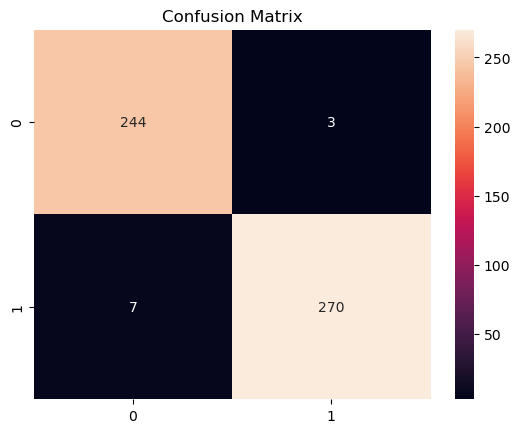

In [50]:
# ============================
# 8. Evaluasi Model
# ============================

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

In [51]:
# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       247
        spam       0.99      0.97      0.98       277

    accuracy                           0.98       524
   macro avg       0.98      0.98      0.98       524
weighted avg       0.98      0.98      0.98       524



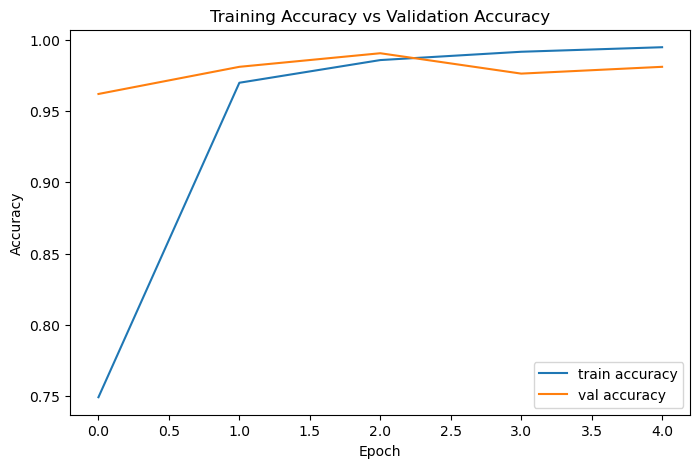

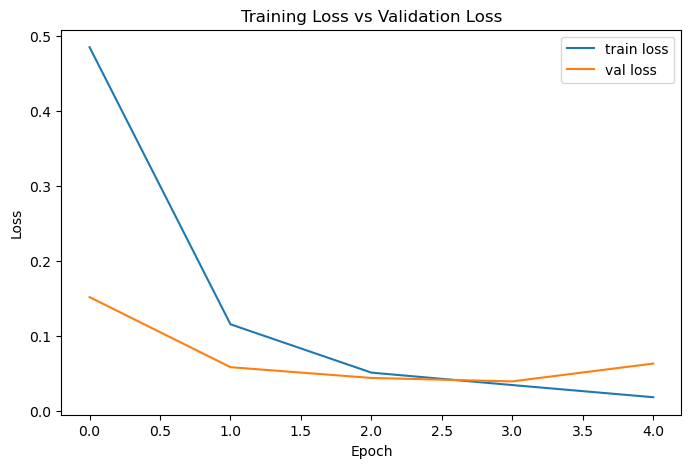

In [52]:
# ============================
# 9. Visualisasi Akurasi Training
# ============================
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Training Accuracy vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Training Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()